In [1]:
#!pip install lightgbm -U imbalanced-learn

In [2]:
#import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import joblib
import warnings
warnings.filterwarnings("ignore")

#Ml libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve,
    f1_score, recall_score, precision_score
) 
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import shap 


import sys
sys.path.append('..')
import config


# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed
np.random.seed(config.RANDOM_SEED)

print("Libraries imported successfully")
print(f"XGBoost version: {xgb.__version__}")
print(f"LightGBM version: {lgb.__version__}")

Configuration loaded successfully!
Project root: C:\Users\hp\Desktop\gaf\Ghana-Armed-Forces-Personnel-Deployment-and-Attrition-Risk-Modeling
Random seed: 42
Target sample size: 1000 personnel
Libraries imported successfully
XGBoost version: 3.0.0
LightGBM version: 4.6.0


# Load Dataset 

In [3]:
#load dataset
data_path = config.PROCESSED_DATA_DIR/config.FEATURES_ENGINEERED_FILE
df = pd.read_csv(data_path)

print(f"Data loaded: {df.shape}")
print(f"\nTartfet distribution: ")
print(df['attrition_risk'].value_counts())
print(f"\nTarget distribution (%)")
print(df["attrition_risk"].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))

Data loaded: (1000, 75)

Tartfet distribution: 
attrition_risk
LOW_RISK       726
MEDIUM_RISK    211
HIGH_RISK       63
Name: count, dtype: int64

Target distribution (%)
attrition_risk
LOW_RISK       72.6%
MEDIUM_RISK    21.1%
HIGH_RISK       6.3%
Name: proportion, dtype: object


# Data Preparation 

In [4]:
#sepetate features and targets
X = df.drop(['attrition_risk', 'readiness_score'], axis=1)
y = df['attrition_risk']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

#encode categorical features 
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nCategorical features to encode: {len(categorical_features)}")
print(categorical_features)

#one-hot encode categorical features 
X_encoded = pd.get_dummies(X, columns= categorical_features, drop_first=True)

print(f"\nFeatures after encoding: {X_encoded.shape}")
print(f"Added {X_encoded.shape[1] - X.shape[1]} dummy variables")
      
      

Features shape: (1000, 73)
Target shape: (1000,)

Categorical features to encode: 12
['gender', 'service_branch', 'rank', 'MOS', 'marital_status', 'education_level', 'mental_health_status', 'deployment_type', 'combat_exposure_level', 'financial_stress_indicator', 'relocation_willingness', 'performance_trajectory']

Features after encoding: (1000, 100)
Added 27 dummy variables


In [5]:
#encode target variables (string numeric)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#store mapping 
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Target encoding:")
for label, code in label_mapping.items():
    print(f"{label}: {code}")
    
#HIGH_RISK is encoded as 0 for easier recall calculation 
#remap 

if label_mapping['HIGH_RISK'] != 0:
    print("\n  Remapping labels so HIGH_RISK = 0 (for recall optimization)")
    label_encoder.classes_ = np.array(['HIGH_RISK', 'LOW_RISK', 'MEDIUM_RISK'])
    y_encoded = label_encoder.transform(y)
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("New mapping:")
    for label, code in label_mapping.items():
        print(f"  {label}: {code}")

Target encoding:
HIGH_RISK: 0
LOW_RISK: 1
MEDIUM_RISK: 2


In [6]:
#train/val/test split (60/20/20 stratified)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, y_encoded, 
    test_size=config.TEST_SIZE, 
    stratify=y_encoded, 
    random_state=config.RANDOM_SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=config.VAL_SIZE, 
    stratify=y_temp, 
    random_state=config.RANDOM_SEED
)

print("Dataset splits:")
print(f"  Training: {X_train.shape[0]} samples ({X_train.shape[0]/len(df):.1%})")
print(f"  Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(df):.1%})")
print(f"  Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(df):.1%})")

# Check stratification
print("\nClass distribution in splits:")
print(f"  Training: {np.bincount(y_train)}")
print(f"  Validation: {np.bincount(y_val)}")
print(f"  Test: {np.bincount(y_test)}")

Dataset splits:
  Training: 600 samples (60.0%)
  Validation: 200 samples (20.0%)
  Test: 200 samples (20.0%)

Class distribution in splits:
  Training: [ 37 436 127]
  Validation: [ 13 145  42]
  Test: [ 13 145  42]


# Handling Class Imbalance with SMOTE 

In [7]:
print("Class distribution before smote")
print(f"class 0 (HIGH_RISK): {np.sum(y_train == 0)}")
print(f" class 1 (HIGH_RISK): {np.sum(y_train == 1)}")
print(f" class 2 (MEDIUM_RISK): {np.sum(y_train == 2)}")

#appky smote to balance classes 
smote = SMOTE(random_state=config.RANDOM_SEED)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nClass distribution AFTER SMOTE:")
print(f"  Class 0 (HIGH_RISK): {np.sum(y_train_balanced == 0)}")
print(f"  Class 1 (LOW_RISK): {np.sum(y_train_balanced == 1)}")
print(f"  Class 2 (MEDIUM_RISK): {np.sum(y_train_balanced == 2)}")
print(f"\nTraining set increased from {len(y_train)} to {len(y_train_balanced)} samples")

Class distribution before smote
class 0 (HIGH_RISK): 37
 class 1 (HIGH_RISK): 436
 class 2 (MEDIUM_RISK): 127

Class distribution AFTER SMOTE:
  Class 0 (HIGH_RISK): 436
  Class 1 (LOW_RISK): 436
  Class 2 (MEDIUM_RISK): 436

Training set increased from 600 to 1308 samples


# Feature Scaling 

In [8]:
#standardize features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#store feature names 
feature_names = X_encoded.columns.tolist()

print(f"Features scaled using standardscaler")
print(f"Total features: {len(feature_names)}")

Features scaled using standardscaler
Total features: 100


In [9]:
def calculate_high_risk_recall(y_true, y_pred):
    from sklearn.metrics import recall_score
    # Get per-class recall (returns array of 3 values)
    per_class_recall = recall_score(y_true, y_pred, labels=[0, 1, 2], average=None)
    # Return HIGH_RISK recall (first element)
    return per_class_recall[0]

print("Helper function loaded")

Helper function loaded


# Model Training 

### Baseline: Logistic Regression 

In [10]:
print("Training Logistic Regression....")

lr_model = LogisticRegression(
    #multi_class="multinomial",
    max_iter=1000,
    random_state=config.RANDOM_SEED,
    n_jobs=-1
)

lr_model.fit(X_train_scaled, y_train_balanced)

#validation prediciton 
y_val_pred_lr = lr_model.predict(X_val_scaled)
y_val_proba_lr = lr_model.predict_proba(X_val_scaled)

#calculate metrics 
recall_high_risk_lr = calculate_high_risk_recall(y_val, y_val_pred_lr)
f1_lr = f1_score(y_val, y_val_pred_lr, average="weighted")

print(f"\nLogistic Regression trained..")
print(f"Validation Recall (HIGH_RISK): {recall_high_risk_lr:.3f}")
print(f"Validation F1-score (weighted): {f1_lr:.3f}")

Training Logistic Regression....

Logistic Regression trained..
Validation Recall (HIGH_RISK): 0.692
Validation F1-score (weighted): 0.823


### Random Forest 

In [11]:
print("Training Random Forest....")

rf_model = RandomForestClassifier(
    n_estimators=350,
    max_depth=4,
    min_samples_split=10,
    random_state=config.RANDOM_SEED,
    n_jobs=-1

)

rf_model.fit(X_train_balanced, y_train_balanced)

#validation predication
y_val_pred_rf = rf_model.predict(X_val)
y_val_proba_rf = rf_model.predict_proba(X_val)

# Calculate metrics
recall_high_risk_rf = calculate_high_risk_recall(y_val, y_val_pred_rf)
f1_rf = f1_score(y_val, y_val_pred_rf, average='weighted')

print("\n Random Forest trained")
print(f"Validation Recall (HIGH_RISK): {recall_high_risk_rf:.3f}")
print(f"Validation F1-Score (weighted): {f1_rf:.3f}")

Training Random Forest....

 Random Forest trained
Validation Recall (HIGH_RISK): 0.692
Validation F1-Score (weighted): 0.812


### XGBoost 

In [12]:
print("Training XGBoost....")

xgb_model = xgb.XGBClassifier(
    n_estimators = 450, 
    max_depth=3,
    learning_rate=0.01,
    objective='multi:softmax',
    num_class=3,
    random_state=config.RANDOM_SEED,
    eval_metric='mlogloss',
    tree_method='hist'
)

xgb_model.fit(
    X_train_balanced, y_train_balanced,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Validation predictions
y_val_pred_xgb = xgb_model.predict(X_val)
y_val_proba_xgb = xgb_model.predict_proba(X_val)

# Calculate metrics
recall_high_risk_xgb = calculate_high_risk_recall(y_val, y_val_pred_xgb)
f1_xgb = f1_score(y_val, y_val_pred_xgb, average='weighted')

print("\n XGBoost trained")
print(f"Validation Recall (HIGH_RISK): {recall_high_risk_xgb:.3f}")
print(f"Validation F1-Score (weighted): {f1_xgb:.3f}")

Training XGBoost....

 XGBoost trained
Validation Recall (HIGH_RISK): 0.846
Validation F1-Score (weighted): 0.837


### LightGBM

In [13]:
print("Training LightGBM...")

lgb_model = lgb.LGBMClassifier(
    n_estimators=450,
    max_depth=2,
    learning_rate=0.1,
    objective='multiclass',
    num_class=3,
    random_state=config.RANDOM_SEED,
    verbose=-1
)

lgb_model.fit(
    X_train_balanced, y_train_balanced,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
)

# Validation predictions
y_val_pred_lgb = lgb_model.predict(X_val)
y_val_proba_lgb = lgb_model.predict_proba(X_val)

# Calculate metrics
recall_high_risk_lgb = calculate_high_risk_recall(y_val, y_val_pred_lgb)
f1_lgb = f1_score(y_val, y_val_pred_lgb, average='weighted')

print("\n LightGBM trained")
print(f"Validation Recall (HIGH_RISK): {recall_high_risk_lgb:.3f}")
print(f"Validation F1-Score (weighted): {f1_lgb:.3f}")

Training LightGBM...

 LightGBM trained
Validation Recall (HIGH_RISK): 0.769
Validation F1-Score (weighted): 0.823


--------------------------------------------------------------------------------
HYPERPARAMETER TUNING - Optimizing for HIGH_RISK Recall
--------------------------------------------------------------------------------

1. Tuning XGBoost...
------------------------------------------------------------
Testing 64 parameter combinations...
This may take 5-10 minutes...

Fitting 5 folds for each of 64 candidates, totalling 320 fits

 XGBoost Tuning Complete!
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': 2, 'subsample': 0.8}
Best CV score (HIGH_RISK recall): 1.000

Tuned XGBoost Performance:
  Validation Recall (HIGH_RISK): 0.615 (was 0.846)
  Validation F1-Score: 0.837 (was 0.837)
  Improvement in Recall: -0.231

2. Tuning LightGBM...
------------------------------------------------------------
Fitting 3 folds for each of 288 candidates, totalling 864 fits

 LightGBM Tuning Complete!
Best parameters: {'colsample_bytr

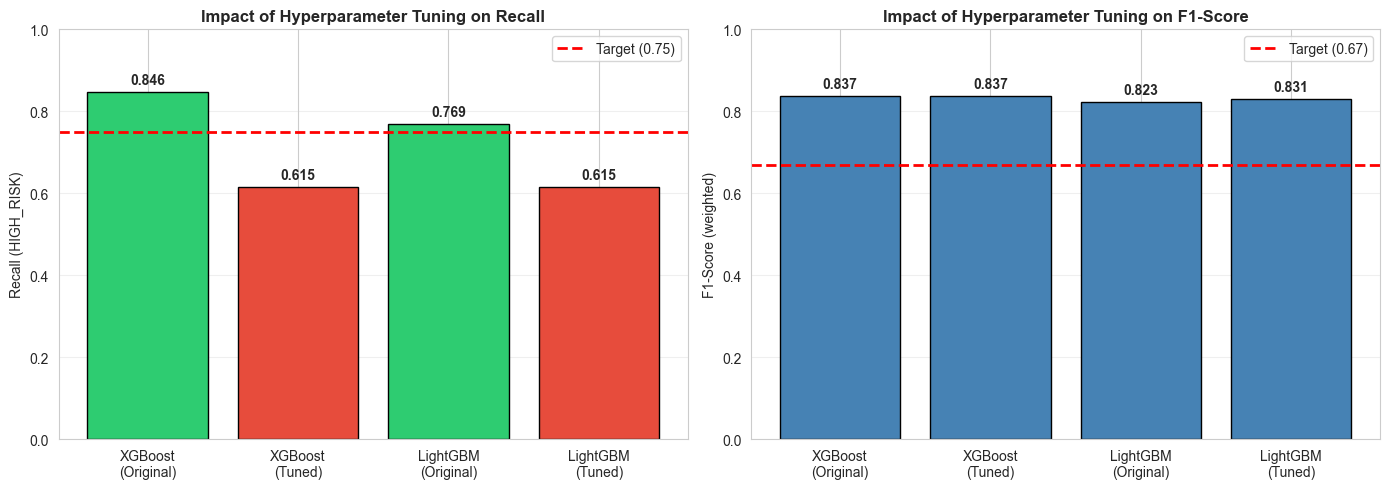


 Tuning visualization saved


In [14]:
# HYPERPARAMETER TUNING FOR ATTRITION MODEL

print("-"*80)
print("HYPERPARAMETER TUNING - Optimizing for HIGH_RISK Recall")
print("-"*80)

from sklearn.metrics import make_scorer

def high_risk_recall_scorer(y_true, y_pred):
    """Custom scorer for HIGH_RISK recall."""
    per_class_recall = recall_score(y_true, y_pred, labels=[0, 1, 2], average=None)
    return per_class_recall[0]

custom_scorer = make_scorer(high_risk_recall_scorer)


print("\n1. Tuning XGBoost...")
print("-" * 60)

# Parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 2, 3]  # Helps with class imbalance
}

xgb_param_grid_fast = {
    'n_estimators': [200, 300],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'scale_pos_weight': [2, 3]  # Weight for minority class
}

# Create base model
xgb_base = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    random_state=config.RANDOM_SEED,
    eval_metric='mlogloss',
    tree_method='hist'
)

# Grid search with cross-validation
# Using 3-fold CV to save time (you can increase to 5-fold for better results)
xgb_grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_param_grid_fast,  # Use xgb_param_grid for exhaustive search
    scoring=custom_scorer,  # Optimize for HIGH_RISK recall
    cv=5,  
    verbose=2,
    n_jobs=-1,
    refit=True
)

print(f"Testing {len(xgb_param_grid_fast['n_estimators']) * len(xgb_param_grid_fast['max_depth']) * len(xgb_param_grid_fast['learning_rate']) * len(xgb_param_grid_fast['min_child_weight']) * len(xgb_param_grid_fast['subsample']) * len(xgb_param_grid_fast['scale_pos_weight'])} parameter combinations...")
print("This may take 5-10 minutes...\n")

# Fit grid search
xgb_grid.fit(X_train_balanced, y_train_balanced)

# Best parameters
print("\n XGBoost Tuning Complete!")
print(f"Best parameters: {xgb_grid.best_params_}")
print(f"Best CV score (HIGH_RISK recall): {xgb_grid.best_score_:.3f}")

# Get tuned model
xgb_model_tuned = xgb_grid.best_estimator_

# Validation predictions with tuned model
y_val_pred_xgb_tuned = xgb_model_tuned.predict(X_val)
y_val_proba_xgb_tuned = xgb_model_tuned.predict_proba(X_val)

recall_high_risk_xgb_tuned = calculate_high_risk_recall(y_val, y_val_pred_xgb_tuned)
f1_xgb_tuned = f1_score(y_val, y_val_pred_xgb_tuned, average='weighted')

print(f"\nTuned XGBoost Performance:")
print(f"  Validation Recall (HIGH_RISK): {recall_high_risk_xgb_tuned:.3f} (was {recall_high_risk_xgb:.3f})")
print(f"  Validation F1-Score: {f1_xgb_tuned:.3f} (was {f1_xgb:.3f})")
print(f"  Improvement in Recall: {(recall_high_risk_xgb_tuned - recall_high_risk_xgb):.3f}")



print("\n" + "="*60)
print("2. Tuning LightGBM...")
print("-" * 60)

# Parameter grid for LightGBM
lgb_param_grid_fast = {
    'n_estimators': [200, 300],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'min_child_samples': [20, 30],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create base model
lgb_base = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    random_state=config.RANDOM_SEED,
    verbose=-1
)

# Grid search
lgb_grid = GridSearchCV(
    estimator=lgb_base,
    param_grid=lgb_param_grid_fast,
    scoring=custom_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1,
    refit=True
)


# Fit
lgb_grid.fit(X_train_balanced, y_train_balanced)

print("\n LightGBM Tuning Complete!")
print(f"Best parameters: {lgb_grid.best_params_}")
print(f"Best CV score (HIGH_RISK recall): {lgb_grid.best_score_:.3f}")

# Get tuned model
lgb_model_tuned = lgb_grid.best_estimator_

# Validation predictions
y_val_pred_lgb_tuned = lgb_model_tuned.predict(X_val)
y_val_proba_lgb_tuned = lgb_model_tuned.predict_proba(X_val)

recall_high_risk_lgb_tuned = calculate_high_risk_recall(y_val, y_val_pred_lgb_tuned)
f1_lgb_tuned = f1_score(y_val, y_val_pred_lgb_tuned, average='weighted')

print(f"\nTuned LightGBM Performance:")
print(f"  Validation Recall (HIGH_RISK): {recall_high_risk_lgb_tuned:.3f} (was {recall_high_risk_lgb:.3f})")
print(f"  Validation F1-Score: {f1_lgb_tuned:.3f} (was {f1_lgb:.3f})")
print(f"  Improvement in Recall: {(recall_high_risk_lgb_tuned - recall_high_risk_lgb):.3f}")





print("\n" + "-"*80)
print("TUNING SUMMARY - Before vs After")
print("-"*80)

tuning_comparison = pd.DataFrame({
    'Model': ['XGBoost (Original)', 'XGBoost (Tuned)', 
              'LightGBM (Original)', 'LightGBM (Tuned)'],
    'Recall (HIGH_RISK)': [
        recall_high_risk_xgb, recall_high_risk_xgb_tuned,
        recall_high_risk_lgb, recall_high_risk_lgb_tuned
    ],
    'F1-Score': [f1_xgb, f1_xgb_tuned, f1_lgb, f1_lgb_tuned],
    'Improvement': [
        0, recall_high_risk_xgb_tuned - recall_high_risk_xgb,
        0, recall_high_risk_lgb_tuned - recall_high_risk_lgb
    ]
})

tuning_comparison = tuning_comparison.round(3)
print(tuning_comparison.to_string(index=False))

# Identify best tuned model
best_tuned_recall = max(recall_high_risk_xgb_tuned, recall_high_risk_lgb_tuned)
if recall_high_risk_xgb_tuned > recall_high_risk_lgb_tuned:
    best_tuned_model_name = 'XGBoost (Tuned)'
    best_tuned_model = xgb_model_tuned
    best_tuned_recall_val = recall_high_risk_xgb_tuned
    best_tuned_f1_val = f1_xgb_tuned
else:
    best_tuned_model_name = 'LightGBM (Tuned)'
    best_tuned_model = lgb_model_tuned
    best_tuned_recall_val = recall_high_risk_lgb_tuned
    best_tuned_f1_val = f1_lgb_tuned

print(f"\n Best Tuned Model: {best_tuned_model_name}")
print(f"   Recall (HIGH_RISK): {best_tuned_recall_val:.3f}")
print(f"   F1-Score: {best_tuned_f1_val:.3f}")




### 5.5.5 Visualize Tuning Results

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Recall comparison
models_comp = ['XGBoost\n(Original)', 'XGBoost\n(Tuned)', 'LightGBM\n(Original)', 'LightGBM\n(Tuned)']
recalls = [recall_high_risk_xgb, recall_high_risk_xgb_tuned, 
           recall_high_risk_lgb, recall_high_risk_lgb_tuned]
colors = ['#e74c3c' if r < 0.75 else '#2ecc71' for r in recalls]

axes[0].bar(models_comp, recalls, color=colors, edgecolor='black')
axes[0].axhline(y=0.75, color='red', linestyle='--', linewidth=2, label='Target (0.75)')
axes[0].set_ylabel('Recall (HIGH_RISK)')
axes[0].set_title('Impact of Hyperparameter Tuning on Recall', fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Add value labels
for i, v in enumerate(recalls):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 2: F1-Score comparison
f1_scores = [f1_xgb, f1_xgb_tuned, f1_lgb, f1_lgb_tuned]
axes[1].bar(models_comp, f1_scores, color='steelblue', edgecolor='black')
axes[1].axhline(y=0.67, color='red', linestyle='--', linewidth=2, label='Target (0.67)')
axes[1].set_ylabel('F1-Score (weighted)')
axes[1].set_title('Impact of Hyperparameter Tuning on F1-Score', fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'attrition_hyperparameter_tuning.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Tuning visualization saved")

# Select the best TUNED model
best_model = best_tuned_model
best_model_name = best_tuned_model_name

# Test set predictions (rest stays the same)
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)


# Model Comparison 

In [15]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': [
        'Logistic Regression', 
        'Random Forest', 
        'XGBoost', 
        'XGBoost (Tuned)',
        'LightGBM',
        'LightGBM (Tuned)'
    ],
    'Recall (HIGH_RISK)': [
        recall_high_risk_lr,
        recall_high_risk_rf,
        recall_high_risk_xgb,
        recall_high_risk_xgb_tuned,
        recall_high_risk_lgb,
        recall_high_risk_lgb_tuned
    ],
    'F1-Score (weighted)': [
        f1_lr, 
        f1_rf, 
        f1_xgb, 
        f1_xgb_tuned,
        f1_lgb,
        f1_lgb_tuned
    ]
})

# Add status indicators
comparison_df['Meets Recall Target (≥0.75)'] = comparison_df['Recall (HIGH_RISK)'].apply(
    lambda x: 'True' if x >= config.ATTRITION_RECALL_TARGET else 'False'
)
comparison_df['Meets F1 Target (≥0.67)'] = comparison_df['F1-Score (weighted)'].apply(
    lambda x: 'True' if x >= config.ATTRITION_F1_TARGET else 'False'
)

# Round metrics
comparison_df['Recall (HIGH_RISK)'] = comparison_df['Recall (HIGH_RISK)'].round(3)
comparison_df['F1-Score (weighted)'] = comparison_df['F1-Score (weighted)'].round(3)

print("\n" + "-"*80)
print("MODEL COMPARISON - VALIDATION SET")
print("-"*80)
print(comparison_df.to_string(index=False))

# Identify best model
best_model_idx = comparison_df['Recall (HIGH_RISK)'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\n Best Model (by HIGH_RISK recall): {best_model_name}")


--------------------------------------------------------------------------------
MODEL COMPARISON - VALIDATION SET
--------------------------------------------------------------------------------
              Model  Recall (HIGH_RISK)  F1-Score (weighted) Meets Recall Target (≥0.75) Meets F1 Target (≥0.67)
Logistic Regression               0.692                0.823                       False                    True
      Random Forest               0.692                0.812                       False                    True
            XGBoost               0.846                0.837                        True                    True
    XGBoost (Tuned)               0.615                0.837                       False                    True
           LightGBM               0.769                0.823                        True                    True
   LightGBM (Tuned)               0.615                0.831                       False                    True

 Best Model

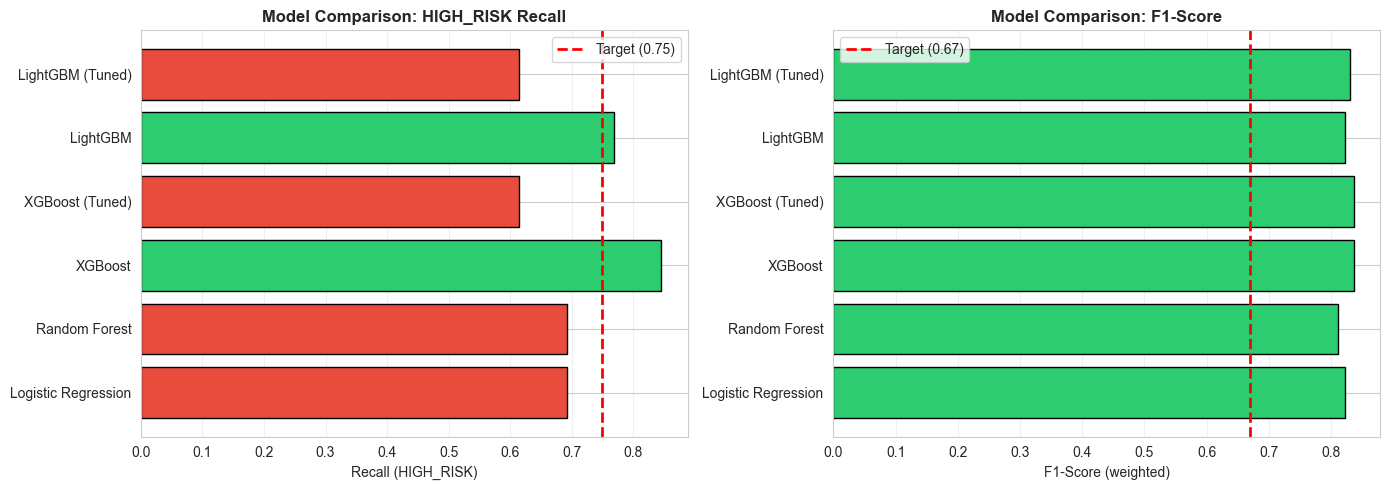

Model comparison visualization saved


In [16]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Recall comparison
colors_recall = ['#e74c3c' if x < 0.75 else '#2ecc71' for x in comparison_df['Recall (HIGH_RISK)']]
axes[0].barh(comparison_df['Model'], comparison_df['Recall (HIGH_RISK)'], color=colors_recall, edgecolor='black')
axes[0].axvline(x=0.75, color='red', linestyle='--', linewidth=2, label='Target (0.75)')
axes[0].set_xlabel('Recall (HIGH_RISK)')
axes[0].set_title('Model Comparison: HIGH_RISK Recall', fontweight='bold')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: F1-Score comparison
colors_f1 = ['#e74c3c' if x < 0.67 else '#2ecc71' for x in comparison_df['F1-Score (weighted)']]
axes[1].barh(comparison_df['Model'], comparison_df['F1-Score (weighted)'], color=colors_f1, edgecolor='black')
axes[1].axvline(x=0.67, color='red', linestyle='--', linewidth=2, label='Target (0.67)')
axes[1].set_xlabel('F1-Score (weighted)')
axes[1].set_title('Model Comparison: F1-Score', fontweight='bold')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'attrition_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Model comparison visualization saved")

# Evaluate Best Model

In [17]:
# Select best model (highest recall)
models_dict = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'LightGBM': lgb_model
}

best_model = models_dict[best_model_name]
print(f"Selected model for test evaluation: {best_model_name}")

# Test set predictions
if best_model_name == 'Logistic Regression':
    y_test_pred = best_model.predict(X_test_scaled)
    y_test_proba = best_model.predict_proba(X_test_scaled)
else:
    y_test_pred = best_model.predict(X_test)
    y_test_proba = best_model.predict_proba(X_test)

Selected model for test evaluation: XGBoost


In [23]:
# Classification report
target_names = label_encoder.classes_
print("\n" + "-"*80)
print("TEST SET EVALUATION - CLASSIFICATION REPORT")
print("-"*80)
print(classification_report(y_test, y_test_pred, target_names=target_names))

# Calculate key metrics
recall_high_risk_test = calculate_high_risk_recall(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')
precision_high_risk_test = precision_score(y_test, y_test_pred, labels=[0], average="weighted")

print("\n" + "-"*80)
print("KEY METRICS - TEST SET")
print("-"*80)
print(f"Recall (HIGH_RISK): {recall_high_risk_test:.3f} (Target: => {config.ATTRITION_RECALL_TARGET})")
print(f"Precision (HIGH_RISK): {precision_high_risk_test:.3f}")
print(f"F1-Score (weighted): {f1_test:.3f} (Target: => {config.ATTRITION_F1_TARGET})")




--------------------------------------------------------------------------------
TEST SET EVALUATION - CLASSIFICATION REPORT
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

   HIGH_RISK       0.53      0.69      0.60        13
    LOW_RISK       0.91      0.89      0.90       145
 MEDIUM_RISK       0.56      0.55      0.55        42

    accuracy                           0.81       200
   macro avg       0.67      0.71      0.68       200
weighted avg       0.81      0.81      0.81       200


--------------------------------------------------------------------------------
KEY METRICS - TEST SET
--------------------------------------------------------------------------------
Recall (HIGH_RISK): 0.692 (Target: => 0.75)
Precision (HIGH_RISK): 0.529
F1-Score (weighted): 0.807 (Target: => 0.67)


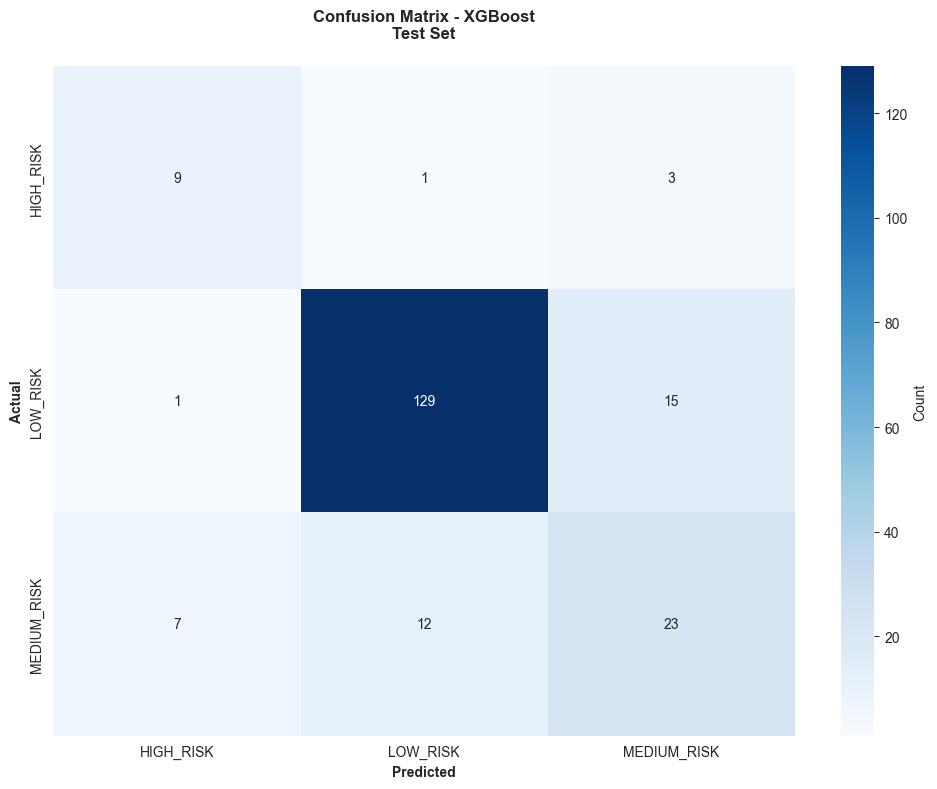

Confusion matrix saved


In [24]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.title(f'Confusion Matrix - {best_model_name}\nTest Set', fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'attrition_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved")

# Feature Importance Analysis 


Top 15 Most Important Features:
------------------------------------------------------------
retention_risk_composite                     : 0.1101
months_until_contract_end                    : 0.0748
contract_pressure                            : 0.0489
mos_retention_rate                           : 0.0461
MOS_Intelligence                             : 0.0342
civilian_job_offers                          : 0.0319
years_of_service                             : 0.0289
contract_urgency_score                       : 0.0274
dependents                                   : 0.0229
promotion_eligible                           : 0.0216
performance_trajectory_Below Average         : 0.0205
MOS_Medical                                  : 0.0186
skills_current                               : 0.0173
wellness_red_flag                            : 0.0173
age                                          : 0.0166


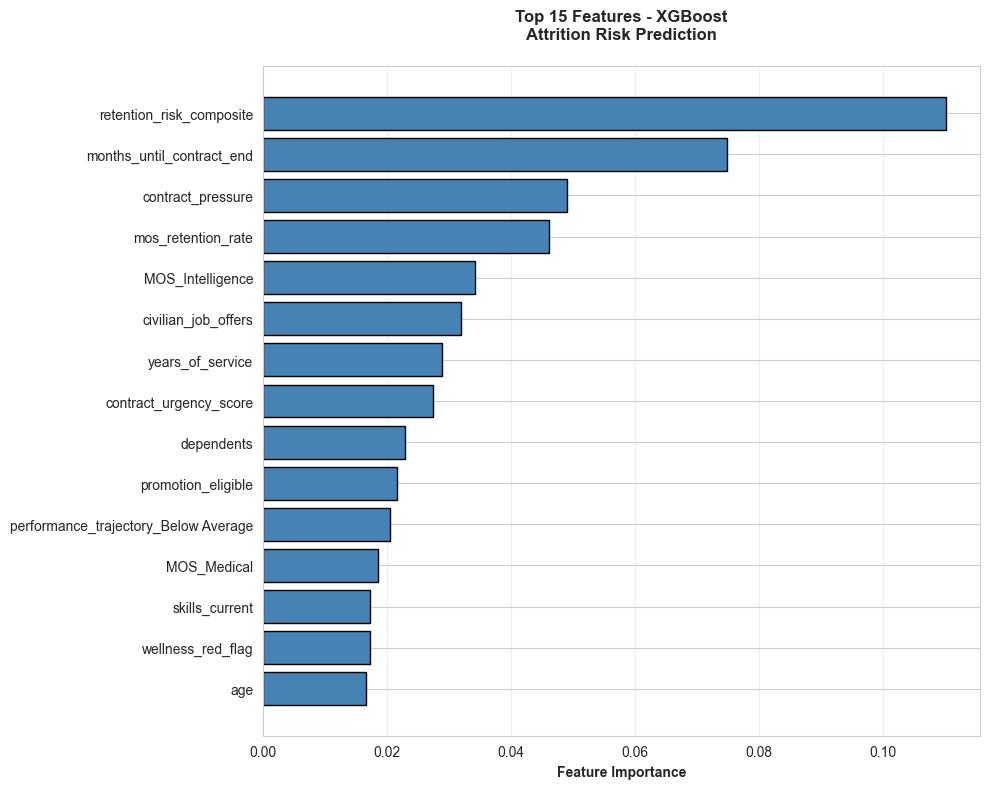


 Feature importance saved


In [25]:
# Get feature importance from best model
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    
    # Create dataframe
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Top 15 features
    top_15 = feature_importance_df.head(15)
    
    print("\nTop 15 Most Important Features:")
    print("-"*60)
    for idx, row in top_15.iterrows():
        print(f"{row['feature']:45s}: {row['importance']:.4f}")
    
    # Visualize
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_15)), top_15['importance'].values, color='steelblue', edgecolor='black')
    plt.yticks(range(len(top_15)), top_15['feature'].values)
    plt.xlabel('Feature Importance', fontweight='bold')
    plt.title(f'Top 15 Features - {best_model_name}\nAttrition Risk Prediction', fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(config.FIGURES_DIR / 'attrition_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save to CSV
    feature_importance_df.to_csv(config.REPORTS_DIR / 'attrition_feature_importance.csv', index=False)
    
    print("\n Feature importance saved")
else:
    print("\n  Selected model does not have feature_importances_ attribute")

# Save Model 

In [26]:
# Save the best model
model_path = config.MODELS_DIR / config.ATTRITION_MODEL_FILE
joblib.dump(best_model, model_path)
print(f" Model saved to: {model_path}")

# Save the scaler (for Logistic Regression)
if best_model_name == 'Logistic Regression':
    scaler_path = config.MODELS_DIR / config.ATTRITION_SCALER_FILE
    joblib.dump(scaler, scaler_path)
    print(f" Scaler saved to: {scaler_path}")

# Save label encoder
label_encoder_path = config.MODELS_DIR / 'attrition_label_encoder.pkl'
joblib.dump(label_encoder, label_encoder_path)
print(f" Label encoder saved to: {label_encoder_path}")

# Save feature names
features_path = config.MODELS_DIR / config.ATTRITION_FEATURES_FILE
with open(features_path, 'w') as f:
    f.write('\n'.join(feature_names))
print(f" Feature names saved to: {features_path}")

 Model saved to: C:\Users\hp\Desktop\gaf\Ghana-Armed-Forces-Personnel-Deployment-and-Attrition-Risk-Modeling\models\attrition_classifier.pkl
 Label encoder saved to: C:\Users\hp\Desktop\gaf\Ghana-Armed-Forces-Personnel-Deployment-and-Attrition-Risk-Modeling\models\attrition_label_encoder.pkl
 Feature names saved to: C:\Users\hp\Desktop\gaf\Ghana-Armed-Forces-Personnel-Deployment-and-Attrition-Risk-Modeling\models\attrition_features.txt


In [27]:
# Save model performance metrics
performance_metrics = {
    'model_name': best_model_name,
    'test_recall_high_risk': recall_high_risk_test,
    'test_precision_high_risk': precision_high_risk_test,
    'test_f1_weighted': f1_test,
    'meets_recall_target': recall_high_risk_test >= config.ATTRITION_RECALL_TARGET,
    'meets_f1_target': f1_test >= config.ATTRITION_F1_TARGET,
    'training_samples': len(y_train_balanced),
    'test_samples': len(y_test),
    'n_features': len(feature_names)
}

metrics_df = pd.DataFrame([performance_metrics])
metrics_path = config.REPORTS_DIR / 'attrition_model_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f" Performance metrics saved to: {metrics_path}")

 Performance metrics saved to: C:\Users\hp\Desktop\gaf\Ghana-Armed-Forces-Personnel-Deployment-and-Attrition-Risk-Modeling\reports\attrition_model_metrics.csv
